In [0]:
# importar os pacotes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [0]:
url = "/Volumes/workspace/default/fraudes_em_cartões_de_crédito/creditcard.csv"

df = pd.read_csv(url)

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Análise Exploratória



In [0]:
#Verificando quantas features e label tem o dataframe

df.shape
print(f'O dataframe tem {df.shape[0]} features')
print(f'O dataframe tem {df.shape[1]} labels')

O dataframe tem 284807 features
O dataframe tem 31 labels


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [0]:
def missing_values_table(df):

  metadados = pd.DataFrame({
      'nome_variavel': df.columns,
      'tipos_de_dados': df.dtypes,
      'numero_de_missing': df.isnull().sum(),
      'percentual_de_missing': df.isnull().sum() * 100 / len(df),
      'unknown': df.isin(['unknown']).sum(),
      'percentual_unknown': df.isin(['unknown']).sum() * 100 / len(df),
      'numero_de_unicos': df.nunique(),
  })

  metadados = metadados.sort_values(by='numero_de_missing', ascending=False).round(1)
  metadados = metadados.reset_index(drop=True)

  return metadados


In [0]:
metadados = missing_values_table(df)
metadados.head(31)

,nome_variavel,tipos_de_dados,numero_de_missing,percentual_de_missing,unknown,percentual_unknown,numero_de_unicos
0,Time,float64,0,0.0,0,0.0,124592
1,V16,float64,0,0.0,0,0.0,275663
2,Amount,float64,0,0.0,0,0.0,32767
3,V28,float64,0,0.0,0,0.0,275663
4,V27,float64,0,0.0,0,0.0,275663
5,V26,float64,0,0.0,0,0.0,275663
6,V25,float64,0,0.0,0,0.0,275663
7,V24,float64,0,0.0,0,0.0,275663
8,V23,float64,0,0.0,0,0.0,275663
9,V22,float64,0,0.0,0,0.0,275663


In [0]:
df.describe().applymap(lambda x: f"{x:0.3f}")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,1.089,1.021,0.999,0.995,0.959,0.915,0.876,0.849,0.838,0.814,0.771,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,-0.535,-0.762,-0.406,-0.649,-0.426,-0.583,-0.468,-0.484,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,-0.093,-0.033,0.140,-0.014,0.051,0.048,0.066,-0.066,-0.004,0.004,-0.062,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,0.454,0.740,0.618,0.663,0.493,0.649,0.523,0.400,0.501,0.459,0.133,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.592,39.421,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


In [0]:
#Separando o Banco de Dados treino e teste
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size = 0.3, random_state = 42)
train.shape, test.shape


((199364, 31), (85443, 31))

In [0]:
df_train_01 = train.copy()
df_test_01 = test.copy()

## Data prep

# Feature Selection

In [0]:
df_train_fs = df_train_01

In [0]:
#Separando o target
X = df_train_fs.drop(['Class'], axis = 1)
y = df_train_fs['Class']

In [0]:
imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)



In [0]:
def correlation_filter(
    X_df: pd.DataFrame,
    threshold: float = 0.85
):
    """
    Remove features altamente correlacionadas entre si (|corr| > threshold).
    Mantém a primeira que aparece (simples e padrão).
    Retorna: X_filtrado, lista_de_removidas
    """
    corr = X_df.corr().abs()
    upper = corr.where(
        np.triu(
            np.ones(corr.shape),
            k=1
        ).astype(bool)
    )
    to_drop = [
        col for col in upper.columns
        if any(upper[col] > threshold)
    ]
    X_f = X_df.drop(columns=to_drop)
    return X_f, to_drop

X_corr, dropped_corr = correlation_filter(X_imp, threshold=0.85)

print(f"[Correlação] Features originais: {X_imp.shape[1]}")
print(f"[Correlação] Removidas por |corr|>0.85: {len(dropped_corr)}")
print(f"[Correlação] Restantes: {X_corr.shape[1]}")

[Correlação] Features originais: 30
[Correlação] Removidas por |corr|>0.85: 0
[Correlação] Restantes: 30


In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_corr, y)

RandomForestClassifier()

In [0]:
print(clf)

RandomForestClassifier()


Numero de features importances selecionadas 7
Features selecionadas ['V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


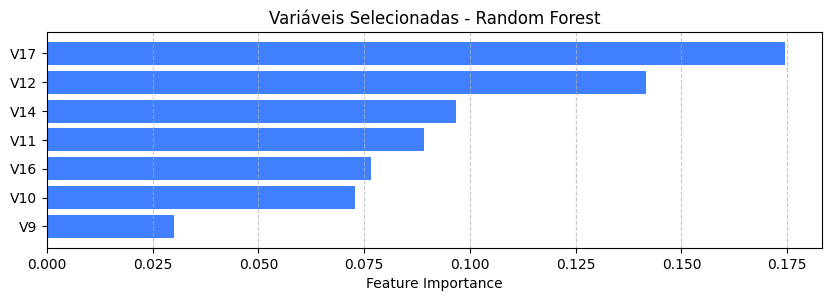

In [0]:
#Encontrando as variaveis mais importantes
import matplotlib.pyplot as plt


feature_importances = clf.feature_importances_

#Criando um dataframe com as features e a sua importância
feature = pd.DataFrame({
    'feature': X_corr.columns,
    'importance': feature_importances})

#Ordenando as variaveis por sua importância
feature.sort_values(by='importance', ascending=False)

#Estabelecendo um limite de corte para as feature importances (30%)
cutoff_max = 0.15

cut_off = cutoff_max * feature_importances.max()

#Selecionando Variaveis acima do limite

selected_features = X_corr.columns[feature_importances > cut_off].tolist()

print(f'Numero de features importances selecionadas {len(selected_features)}')
print(f'Features selecionadas {selected_features}')

#Ordenando as variaveis selecionadas
features = feature.sort_values(by='importance', ascending=True)

#Filtrar o dataframe para apenas features acima da corte
selected_features_df = features[features['importance'] > cut_off]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['feature'], selected_features_df['importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [0]:
 import pickle

with open('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/feat_selec/cred_list_feature.pkl','wb') as pk:
    pickle.dump(selected_features,pk)

In [0]:
# Aplicando no banco de dados test
with open('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/feat_selec/cred_list_feature.pkl','rb') as pk:
    cred_list_feature = pickle.load(pk)

df_test_fs = pd.read_csv('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/data_prep/test.csv')
lista_features = cred_list_feature + ['Class']
df_test_fs_01 = df_test_fs[lista_features]
df_test_fs_01.head()

,V9,V10,V11,V12,V14,V16,V17,Class
0,-7.754485,-12.979660,5.186767,-10.817388,-9.761398,-11.288570,-22.636465,1
1,0.820480,-0.518829,-0.087241,0.978466,-0.225815,-2.443630,0.149377,0
2,-0.885518,0.697167,0.531022,0.112782,-0.254860,2.018267,-0.627434,0
3,-0.441554,-1.265491,-1.301904,0.223784,-0.572613,0.567875,0.590943,0
4,0.331418,0.239633,0.921008,0.849269,0.618307,0.103871,-0.555292,0


In [0]:
abt_train_02 = df_train_fs[lista_features]
abt_test_02 = df_test_fs[lista_features]

In [0]:
abt_train_02.to_csv('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/feat_selec/train_02')
abt_test_02.to_csv('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/feat_selec/test_02')

# Modelo de Machine Learning


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

def calcular_ks_statistic(y_true, y_score):
    """KS = max(TPR - FPR) ao longo dos thresholds."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(tpr - fpr))

def get_scores(model, X):
    """
    Retorna scores contínuos para métricas:
    - preferencialmente predict_proba[:,1]
    - senão decision_function
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        # transformar para 0..1 (opcional); pra AUC não precisa, mas ajuda em gráficos
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    raise ValueError("Modelo não possui predict_proba nem decision_function.")

In [0]:
def avaliar_modelo(
    X_train, y_train, X_test, y_test,
    modelo_ou_search,
    nm_modelo="Modelo",
    top_features=25,
    n_bins=30
):
    """
    - Aceita tanto um modelo quanto um RandomizedSearchCV / GridSearchCV.
    - Se receber um search, usa automaticamente best_estimator_.
    - Gera um dashboard com métricas e gráficos mais interpretáveis.
    """

    # 0) Se for SearchCV, pega o melhor estimador
    if hasattr(modelo_ou_search, "best_estimator_"):
        model = modelo_ou_search.best_estimator_
        best_params = getattr(modelo_ou_search, "best_params_", None)
        best_cv_auc = getattr(modelo_ou_search, "best_score_", None)
        titulo_extra = " (Best Estimator)"
    else:
        model = modelo_ou_search
        best_params = None
        best_cv_auc = None
        titulo_extra = ""

    # 1) Predições e scores
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    y_score_train = get_scores(model, X_train)
    y_score_test  = get_scores(model, X_test)

    # 2) Métricas principais
    auc_train = roc_auc_score(y_train, y_score_train)
    auc_test  = roc_auc_score(y_test, y_score_test)

    gini_train = 2 * auc_train - 1
    gini_test  = 2 * auc_test - 1

    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test  = calcular_ks_statistic(y_test, y_score_test)

    ap_train = average_precision_score(y_train, y_score_train)
    ap_test  = average_precision_score(y_test, y_score_test)

    # 3) Taxa de evento
    event_rate = float(np.mean(y_train))
    non_event_rate = 1 - event_rate

    # 4) Feature importance (melhor prática)
    feature_names = list(X_train.columns)
    imp_df = None

    # XGBoost: preferir GAIN do booster
    if hasattr(model, "get_booster"):
        try:
            booster = model.get_booster()
            gain_dict = booster.get_score(importance_type="gain")
            gain_vals = np.array([gain_dict.get(f, 0.0) for f in feature_names], dtype=float)
            imp_df = pd.DataFrame({"feature": feature_names, "importance": gain_vals})
        except Exception:
            imp_df = None

    # fallback: sklearn-style
    if imp_df is None and hasattr(model, "feature_importances_"):
        imp_df = pd.DataFrame({"feature": feature_names, "importance": model.feature_importances_})

    # fallback: linear models
    if imp_df is None and hasattr(model, "coef_"):
        imp_df = pd.DataFrame({"feature": feature_names, "importance": np.abs(model.coef_[0])})

    if imp_df is not None:
        imp_df = imp_df.sort_values("importance", ascending=False)
        imp_df_plot = imp_df.head(top_features).sort_values("importance", ascending=True)

    # 5) Confusion matrices
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test  = confusion_matrix(y_test, y_pred_test)

    # 6) Curvas ROC e PR
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_score_train)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_score_test)

    prec_tr, rec_tr, _ = precision_recall_curve(y_train, y_score_train)
    prec_te, rec_te, _ = precision_recall_curve(y_test, y_score_test)

    # 7) Deciles (mais completo: evento + volume)
    def decile_table(y_true, scores, q=10):
        df = pd.DataFrame({"y": y_true.values if hasattr(y_true, "values") else y_true, "score": scores})
        # ruído mínimo pra evitar empates no qcut
        df["score"] = df["score"] + np.random.uniform(0, 1e-9, size=len(df))
        df["decile"] = pd.qcut(df["score"], q=q, labels=False, duplicates="drop") + 1
        tab = df.groupby("decile").agg(
            event_rate=("y", "mean"),
            count=("y", "size")
        ).reset_index()
        return tab.sort_values("decile")

    dec_tr = decile_table(y_train, y_score_train, q=10)
    dec_te = decile_table(y_test, y_score_test, q=10)

    # 8) Montagem do dashboard (layout melhor)
    fig = plt.figure(figsize=(18, 22))
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.30)

    ax0 = fig.add_subplot(gs[0, 0])  # evento
    ax1 = fig.add_subplot(gs[0, 1:3])  # importance
    ax2 = fig.add_subplot(gs[1, 0])  # cm train
    ax3 = fig.add_subplot(gs[1, 1])  # cm test
    ax4 = fig.add_subplot(gs[1, 2])  # score dist
    ax5 = fig.add_subplot(gs[2, 0:2])  # ROC
    ax6 = fig.add_subplot(gs[2, 2])  # PR
    ax7 = fig.add_subplot(gs[3, 0])  # gini
    ax8 = fig.add_subplot(gs[3, 1])  # ks
    ax9 = fig.add_subplot(gs[3, 2])  # deciles test

    # ---- Cabeçalho
    title = f" Dashboard — {nm_modelo}{titulo_extra}"
    if best_cv_auc is not None:
        title += f" | Best CV AUC: {best_cv_auc:.4f}"
    fig.suptitle(title, fontsize=16, y=0.995)

    # ---- Plot 1: Event rate
    ax0.bar(["Evento (1)", "Não evento (0)"], [event_rate, non_event_rate])
    ax0.set_title("Taxa de Evento (Treino)")
    ax0.set_ylabel("Proporção")
    ax0.set_ylim(0, 1)

    # ---- Plot 2: Feature importance
    if imp_df is not None:
        ax1.barh(imp_df_plot["feature"], imp_df_plot["importance"])
        ax1.set_title(f"Top {top_features} Importâncias (preferência: gain p/ XGB)")
        ax1.set_xlabel("Importance")
    else:
        ax1.text(0.5, 0.5, "Modelo não fornece importâncias", ha="center", va="center")
        ax1.set_axis_off()

    # ---- Plot 3 e 4: Confusion Matrix (train/test) com números
    def plot_cm(ax, cm, title):
        ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        ax.set_title(title)
        ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
        ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])
        ax.set_xlabel("Predito"); ax.set_ylabel("Real")
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], "d"),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    plot_cm(ax2, cm_train, f"Confusion Matrix — Treino")
    plot_cm(ax3, cm_test,  f"Confusion Matrix — Teste")

    # ---- Plot 5: Distribuição de scores (train/test)
    ax4.hist(y_score_train, bins=n_bins, alpha=0.6, label="Treino")
    ax4.hist(y_score_test,  bins=n_bins, alpha=0.6, label="Teste")
    ax4.set_title("Distribuição do Score (prob)")
    ax4.set_xlabel("Score"); ax4.set_ylabel("Contagem")
    ax4.legend()

    # ---- Plot 6: ROC
    ax5.plot(fpr_tr, tpr_tr, label=f"Treino AUC={auc_train:.4f}")
    ax5.plot(fpr_te, tpr_te, label=f"Teste  AUC={auc_test:.4f}")
    ax5.plot([0, 1], [0, 1], linestyle="--")
    ax5.set_title("ROC Curve")
    ax5.set_xlabel("FPR"); ax5.set_ylabel("TPR")
    ax5.legend(loc="lower right")

    # ---- Plot 7: Precision-Recall
    ax6.plot(rec_tr, prec_tr, label=f"Treino AP={ap_train:.4f}")
    ax6.plot(rec_te, prec_te, label=f"Teste  AP={ap_test:.4f}")
    ax6.set_title("Precision-Recall Curve")
    ax6.set_xlabel("Recall"); ax6.set_ylabel("Precision")
    ax6.legend(loc="lower left")

    # ---- Plot 8: Gini (train/test)
    ax7.bar(["Treino", "Teste"], [gini_train, gini_test])
    ax7.set_title("Gini")
    ax7.set_ylim(-1, 1)
    ax7.text(0, gini_train + 0.02, f"{gini_train:.3f}", ha="center")
    ax7.text(1, gini_test + 0.02,  f"{gini_test:.3f}", ha="center")

    # ---- Plot 9: KS (train/test)
    ax8.bar(["Treino", "Teste"], [ks_train, ks_test])
    ax8.set_title("KS")
    ax8.set_ylim(0, 1)
    ax8.text(0, ks_train + 0.02, f"{ks_train:.3f}", ha="center")
    ax8.text(1, ks_test + 0.02,  f"{ks_test:.3f}", ha="center")

    # ---- Plot 10: Deciles (teste) — evento + volume (dual axis)
    ax9.bar(dec_te["decile"], dec_te["event_rate"])
    ax9.set_title("Deciles — Teste (Taxa de evento)")
    ax9.set_xlabel("Decil (1=baixo score → 10=alto score)")
    ax9.set_ylabel("Event rate")
    ax9.set_ylim(0, 1)

    ax9b = ax9.twinx()
    ax9b.plot(dec_te["decile"], dec_te["count"], marker="o")
    ax9b.set_ylabel("Volume (count)")

    # ---- Rodapé com parâmetros
    if best_params is not None:
        txt = "Best Params:\n" + "\n".join([f"{k}={v}" for k, v in best_params.items()])
        fig.text(0.01, 0.01, txt, fontsize=9)

    plt.show()

    # retorno útil para logs
    return {
        "auc_train": auc_train, "auc_test": auc_test,
        "gini_train": gini_train, "gini_test": gini_test,
        "ks_train": ks_train, "ks_test": ks_test,
        "ap_train": ap_train, "ap_test": ap_test,
        "best_cv_auc": best_cv_auc,
        "best_params": best_params
    }

In [0]:
df_train_m = pd.read_csv('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/feat_selec/train_02')
df_train_mod = df_train_m.drop(['Unnamed: 0'], axis=1)
df_train_mod.head()

,V9,V10,V11,V12,V14,V16,V17,Class
0,1.323156,-0.434426,0.330147,0.582071,-0.215089,-0.896319,-0.298897,0
1,0.015829,-0.359561,0.905251,0.689143,1.074658,-0.508424,0.072520,0
2,1.961027,-0.724328,-2.114621,-3.022907,0.137917,-1.297028,0.968448,0
3,-0.067566,-0.130220,1.401227,0.405652,0.102870,0.521996,-0.043959,0
4,1.381880,-0.659956,1.093326,-2.530624,1.573518,0.891702,-0.389181,0


In [0]:
#Verificando o Balenceamento do target
display(df_train_mod['Class'].value_counts())

0    199008
1       356
Name: Class, dtype: int64

In [0]:
X = df_train_mod.drop(['Class'], axis=1)
y = df_train_mod['Class']

In [0]:
from sklearn.model_selection import train_test_split

# X, y já definidos
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# separa uma parte do treino para calibrar (NÃO é o teste)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

print("Taxa de fraude (train):", y_train.mean())
print("Taxa de fraude (cal):  ", y_cal.mean())
print("Taxa de fraude (test): ", y_test.mean())


Taxa de fraude (train): 0.0017824673288965721
Taxa de fraude (cal):   0.0017914084052882376
Taxa de fraude (test):  0.0017889984952349106


In [0]:
from sklearn.metrics import classification_report,accuracy_score

In [0]:
from xgboost import XGBClassifier

ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Para precision
scale_pos_weight = min(ratio, 100)  

xgb_prec = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",       # ✅ melhor p/ desbalanceado
    tree_method="hist",
    n_jobs=-1,
    random_state=42,

    # Conservador
    n_estimators=800,
    learning_rate=0.03,
    max_depth=2,               # ✅ reduz complexidade
    min_child_weight=20,       # ✅ evita split baseado em poucos positivos
    gamma=0.4,                 # ✅ exige ganho real para split
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10.0,           # ✅ regularização forte
    reg_alpha=0.2,             # ✅ ajuda a podar
    scale_pos_weight=scale_pos_weight
)

xgb_prec.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=20, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=-1, num_parallel_tree=None, ...)

In [0]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, confusion_matrix

# calibra sem usar test (use X_cal, y_cal)
calibrated = CalibratedClassifierCV(estimator=xgb_prec, method="sigmoid", cv="prefit")
calibrated.fit(X_cal, y_cal)

proba_test = calibrated.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, proba_test)

target_precision = 0.4  # 🎯 ajuste aqui (0.30, 0.40...)
valid = np.where(prec[:-1] >= target_precision)[0]

if len(valid) == 0:
    best_thr = 0.99
else:
    best_idx = valid[np.argmax(rec[valid])]
    best_thr = thr[best_idx]

y_pred = (proba_test >= best_thr).astype(int)

print("Threshold:", best_thr)
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("CM:\n", confusion_matrix(y_test, y_pred))

Threshold: 0.015573270618915558
Precision: 0.4
Recall: 0.822429906542056
CM:
 [[59571   132]
 [   19    88]]


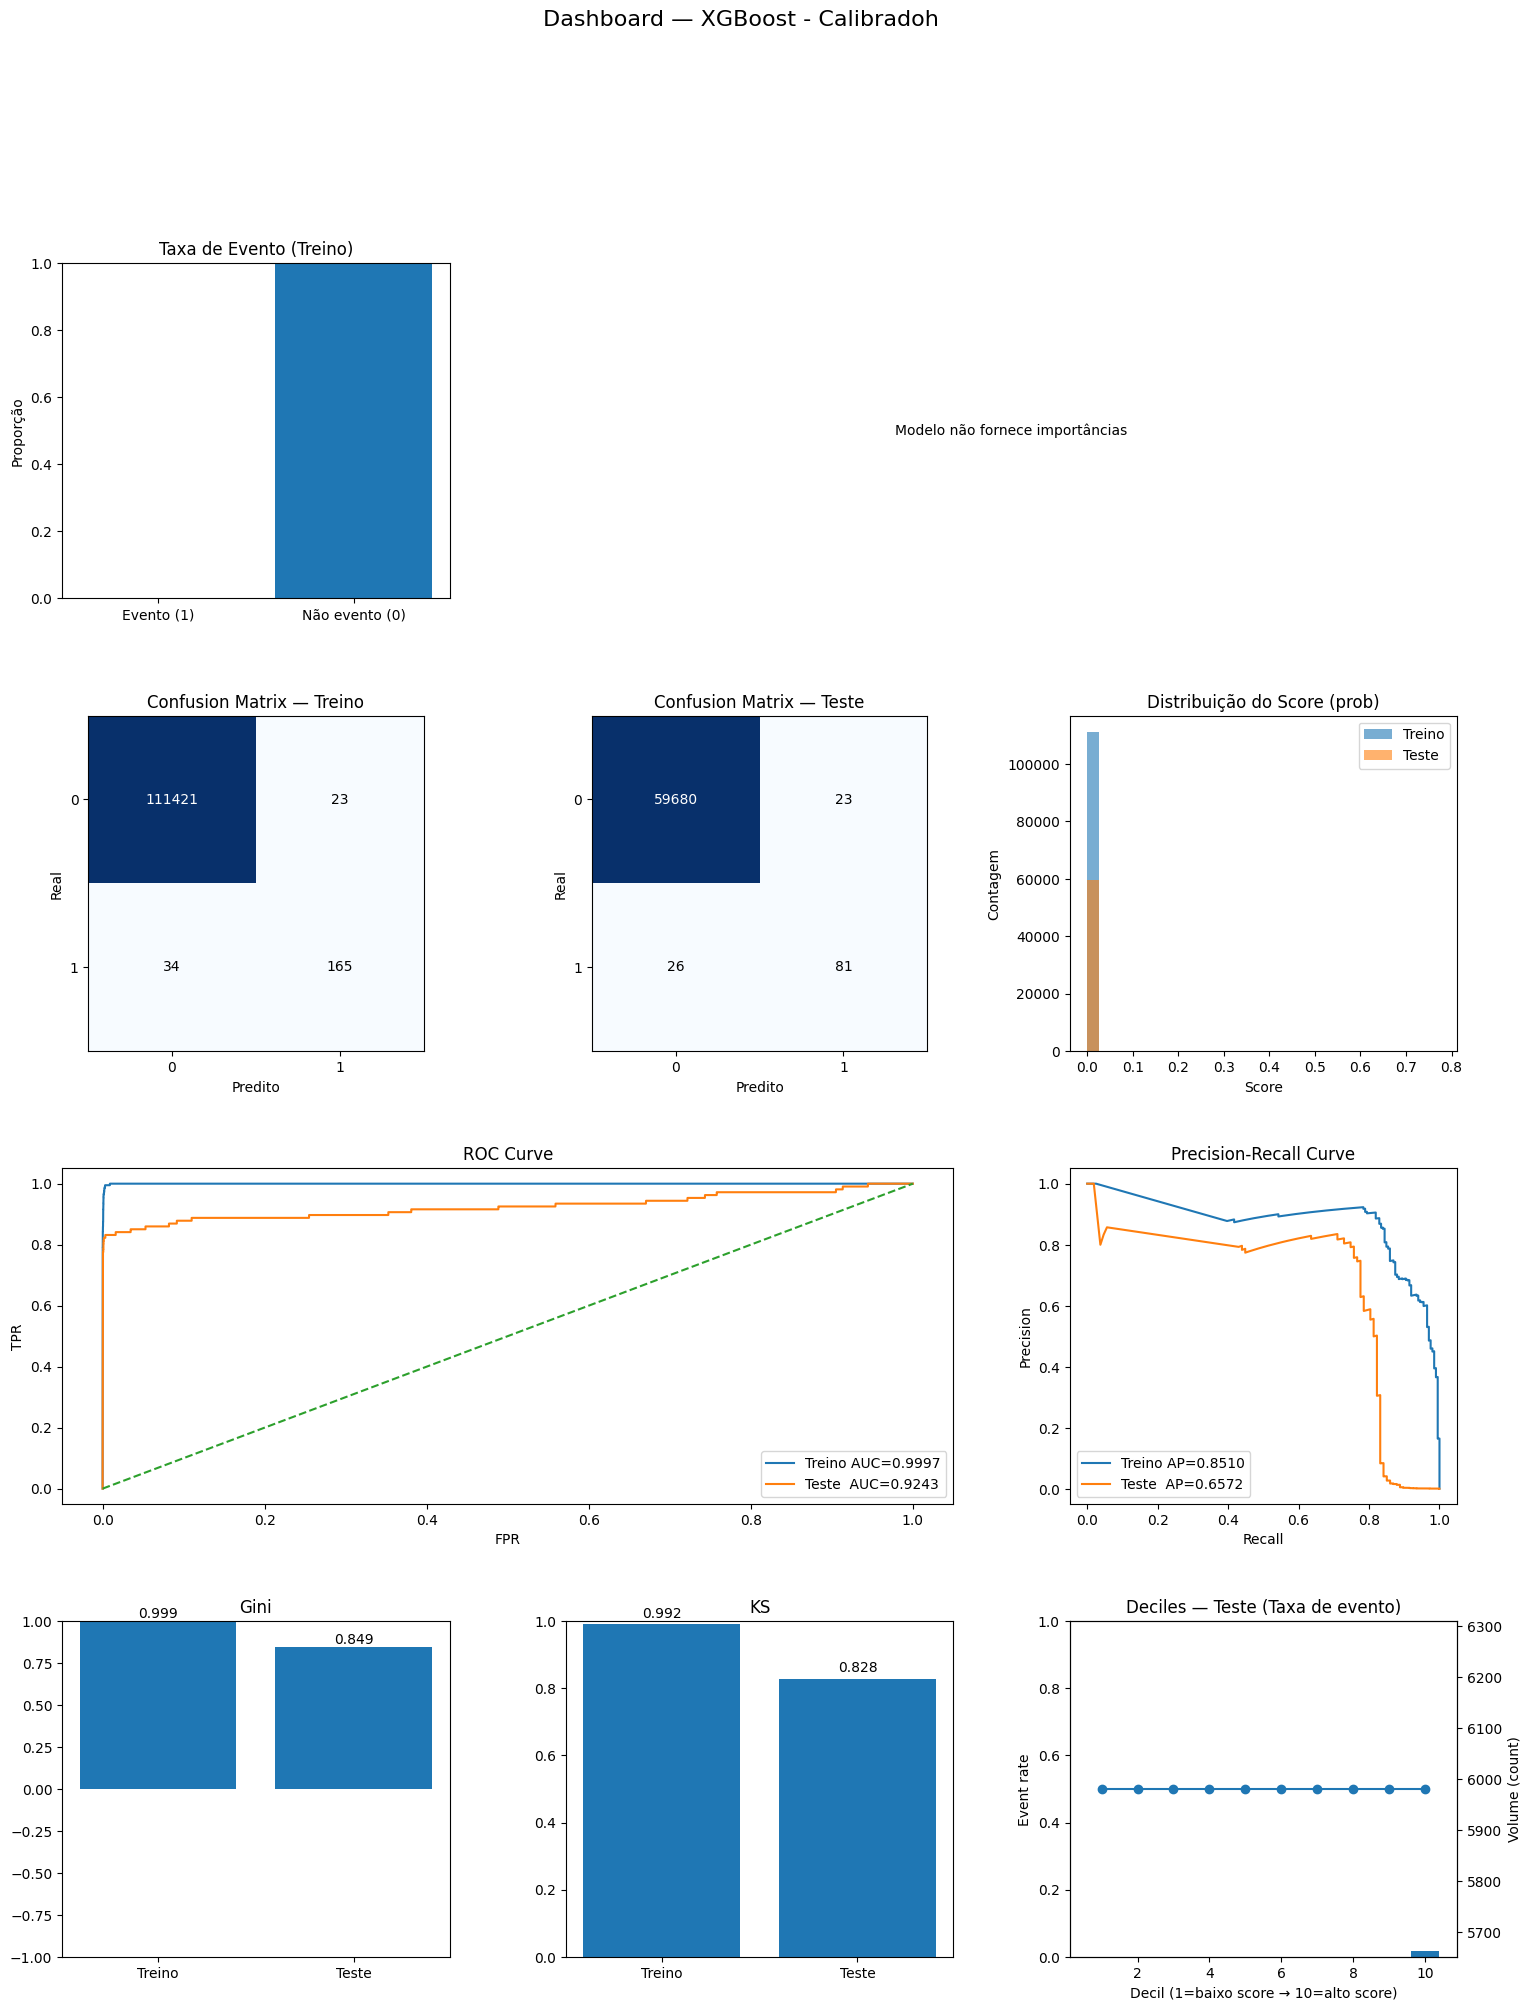

{'auc_train': 0.9997218784782099, 'auc_test': 0.9242778231999174, 'gini_train': 0.9994437569564198, 'gini_test': 0.8485556463998347, 'ks_train': 0.9919150416307516, 'ks_test': 0.8284257855199436, 'ap_train': 0.8510155116187147, 'ap_test': 0.6571789144826026, 'best_cv_auc': None, 'best_params': None}


In [0]:

resultados = avaliar_modelo(
    X_train, y_train,
    X_test, y_test,
    modelo_ou_search=calibrated,    
    nm_modelo="XGBoost - Calibradoh",
    top_features=25
)

print(resultados)